In [1]:
#coding=utf-8
%matplotlib inline
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['SimHei']  
# plt.rcParams['axes.unicode_minus'] = False 
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import jieba as jb
import re
data_train = pd.read_excel('D:\\files\\Courses\\Final Year Project\\archive\\train.xlsx')

C:\Users\Gao\anaconda3\envs\pytorch\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [2]:
def emotion2sentiment(emotion):
    if emotion == 'angry':
        return 0
    elif emotion == 'fear':
        return 1
    elif emotion == 'sad':
        return 2
    elif emotion == 'neural':
        return 3
    elif emotion == 'surprise':
        return 4
    elif emotion == 'happy':
        return 5
    
def sentiment2emotion(sentiment):
    if sentiment == 0:
        return "angry"
    elif sentiment == 1:
        return "fear"
    elif sentiment == 2:
        return "sad"
    elif sentiment == 3:
        return "neural"
    elif sentiment == 4:
        return "surprise"
    elif sentiment == 5:
        return "happy"
    
data_train['sentiment'] = data_train.emotion.apply(emotion2sentiment)

In [3]:
# def remove_symbol(s_line):
#     # 剔除英文、数字，以及空格
#     special_regex = re.compile(r"[a-zA-Z0-9\s]+")
#     # 剔除英文标点符号和特殊符号
#     en_regex = re.compile(r"[.…{|}#$%&\'()*+,!-_./:~^;<=>?@★●，。]+")
#     # 剔除中文标点符号
#     zn_regex = re.compile(r"[《》、，“”；～？！：（）【】]+")

#     s_line = special_regex.sub(r"", s_line)
#     s_line = en_regex.sub(r"", s_line)
#     s_line = zn_regex.sub(r"", s_line)
#     return s_line


def remove_symbol(line):
    line = str(line)
    if line.strip()=='':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('',line)
    return line


data_train['remove_symbol_text'] = data_train.text.astype(str).apply(remove_symbol)

In [4]:
# import jieba

# def chinese_word_cut(mytext):
#     return " ".join(jieba.cut(mytext))

In [5]:
import thulac   
thu1 = thulac.thulac(seg_only=True)  #默认模式
def chinese_word_cut(mytext):
    text = thu1.cut(mytext, text=True)  #进行一句话分词
    return text
# text = thu1.cut("我爱北京天安门")  #进行一句话分词
# print(text)

Model loaded succeed


In [6]:
data_train['cut_text'] = data_train['remove_symbol_text'].astype(str).apply(chinese_word_cut)
# data_train.head()

In [7]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

def get_custom_stopwords(stop_words_file):
    with open(stop_words_file) as f:
        stopwords = f.read()
    stopwords_list = stopwords.split('\n')
    custom_stopwords_list = [i for i in stopwords_list]
    return custom_stopwords_list

stop_words_file = '哈工大停用词表.txt'
stopwords = get_custom_stopwords(stop_words_file)
# print(type(stopwords))
vect = CountVectorizer(max_df = 0.8, 
                       min_df = 3, 
                       token_pattern=u'(?u)\\b[^\\d\\W]\\w+\\b', 
                       stop_words=stopwords)
# vect = TfidfVectorizer(use_idf=True, smooth_idf=True,max_df = 0.8, 
#                        min_df = 3, 
#                        token_pattern=u'(?u)\\b[^\\d\\W]\\w+\\b', 
#                        stop_words=stopwords)

In [8]:

# 设置最频繁使用的50000个词
MAX_NB_WORDS = 50000
# 每条cut_review最大的长度
MAX_SEQUENCE_LENGTH = 250
# 设置Embeddingceng层的维度
EMBEDDING_DIM = 100
 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_train['cut_text'].values)
# tokenizer.save_pretrained("./tokenizer_lstm.json")
word_index = tokenizer.word_index
print('共有 %s 个不相同的词语.' % len(word_index))

js = tokenizer.to_json()
json_file = open('tokenizer_json.json', 'w')
json_file.write(js)
json_file.close()

共有 51131 个不相同的词语.


Tokenizer test

In [9]:
# from tensorflow import keras
# # 设置最频繁使用的50000个词
# MAX_NB_WORDS = 50000
# # 每条cut_review最大的长度
# MAX_SEQUENCE_LENGTH = 250
# # 设置Embeddingceng层的维度
# EMBEDDING_DIM = 100
 
# # tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
# # tokenizer.fit_on_texts(data_train['cut_text'].values)
# # word_index = tokenizer.word_index
# # print('共有 %s 个不相同的词语.' % len(word_index))

# f = open('tokenizer_json.json', 'r')
# content = f.read()
# print(type(content))
# f.close()
# tokenizer = keras.preprocessing.text.tokenizer_from_json(content)

In [10]:
X = tokenizer.texts_to_sequences(data_train['cut_text'].values)
# print(X.shape)
# print(type(X))
# 填充X,让X的各个列的长度统一
X_train = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
# print(X_train.shape)
# print(type(X_train))
# X_train = pad_sequences(X)
# X_train = data_train['cut_text']
# X_train = vect.fit_transform(X_train).A
# X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
 
#多类标签的onehot展开
Y_train = pd.get_dummies(data_train['sentiment']).values
 
print(X_train.shape)
# print(X_train1.shape)
# print(type(X_train))
# print(type(X_train1))
print(Y_train.shape)

(22214, 250)
(22214, 6)


In [11]:
#Define the model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(36, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 36)                19728     
                                                                 
 dense (Dense)               (None, 6)                 222       
                                                                 
Total params: 5,019,950
Trainable params: 5,019,950
Non-trainable params: 0
_________________________________________________________________
None


In [12]:
epochs = 5
batch_size = 64
 
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
model.save("LSTM_model_20230301")

Epoch 1/5
313/313 [==============================] - 57s 176ms/step - loss: 1.3146 - accuracy: 0.4967 - val_loss: 1.0578 - val_accuracy: 0.6220
Epoch 2/5
313/313 [==============================] - 56s 180ms/step - loss: 0.8343 - accuracy: 0.6998 - val_loss: 0.9145 - val_accuracy: 0.6683
Epoch 3/5
313/313 [==============================] - 59s 188ms/step - loss: 0.5384 - accuracy: 0.8175 - val_loss: 0.9516 - val_accuracy: 0.6665
Epoch 4/5
313/313 [==============================] - 57s 183ms/step - loss: 0.3524 - accuracy: 0.8898 - val_loss: 1.0088 - val_accuracy: 0.6683
Epoch 5/5
313/313 [==============================] - 57s 183ms/step - loss: 0.2432 - accuracy: 0.9244 - val_loss: 1.0912 - val_accuracy: 0.6629


INFO:tensorflow:Assets written to: LSTM_model_20230301\assets


INFO:tensorflow:Assets written to: LSTM_model_20230301\assets


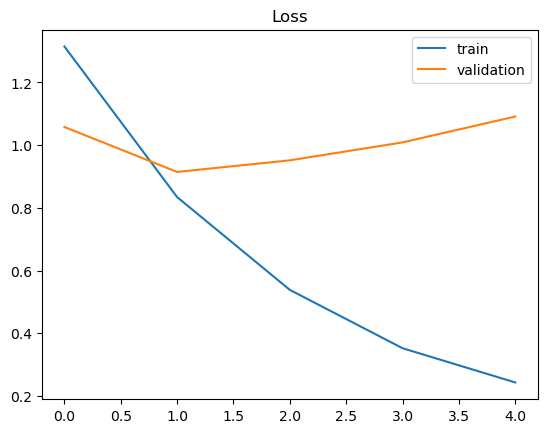

<Figure size 640x480 with 0 Axes>

In [13]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show();
plt.savefig("./Plot of Loss Value of LSTM Training.png")

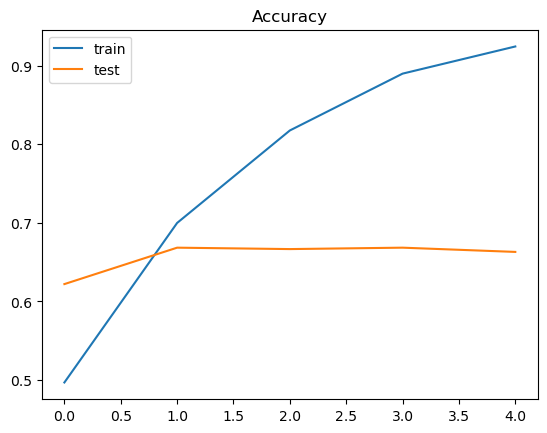

<Figure size 640x480 with 0 Axes>

In [14]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();
plt.savefig("./Plot of Accuracy Value of LSTM Training.png")

In [15]:
data_test = data_train = pd.read_excel('D:\\files\\Courses\\Final Year Project\\archive\\test.xlsx')
data_test['sentiment'] = data_test.emotion.apply(emotion2sentiment)
data_test['remove_symbol_text'] = data_test.text.astype(str).apply(remove_symbol)
data_test['cut_text'] = data_test['remove_symbol_text'].astype(str).apply(chinese_word_cut)
X_test = tokenizer.texts_to_sequences(data_test['cut_text'].values)
#填充X,让X的各个列的长度统一
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
 
#多类标签的onehot展开
Y_test = pd.get_dummies(data_test['sentiment']).values

C:\Users\Gao\anaconda3\envs\pytorch\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [16]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
 
y_pred = model.predict(X_test)
# y_pred.head()

174/174 [==============================] - 5s 29ms/step


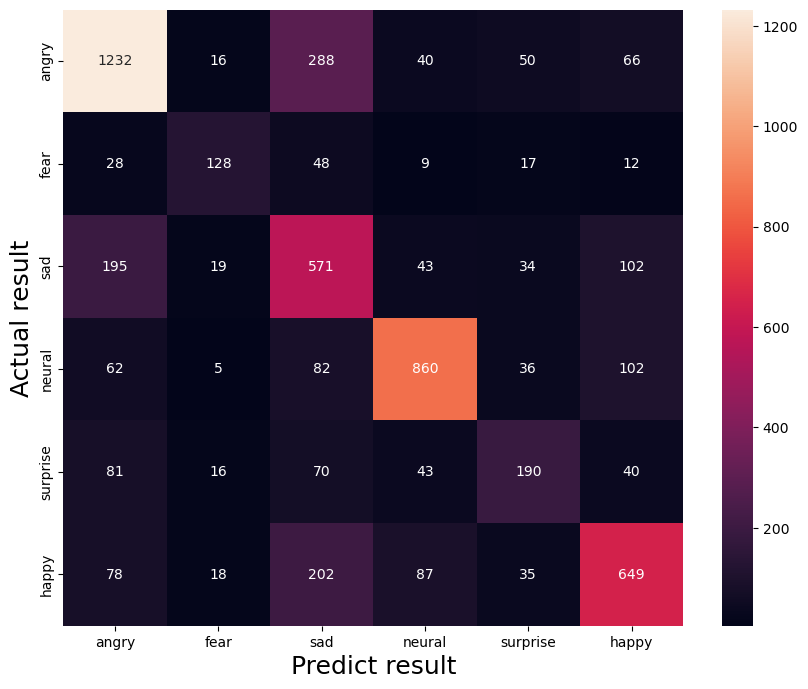

In [17]:
# print(y_pred.shape)
# y_pred = y_pred.argmax(axis = 1)
# Y_test = Y_test.argmax(axis = 1)
 
#生成混淆矩阵
conf_mat = confusion_matrix(Y_test.argmax(axis=1), y_pred.argmax(axis=1))
fig, ax = plt.subplots(figsize=(10,8))
ticklabels = pd.Series(range(len(data_test.emotion.unique()))).apply(sentiment2emotion)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=ticklabels, yticklabels=ticklabels)
plt.ylabel('Actual result',fontsize=18)
plt.xlabel('Predict result',fontsize=18)
plt.savefig("./Plot of LSTM result.png")
# print(Y_test.argmax(axis=1).shape)

In [18]:
from  sklearn.metrics import classification_report
 
print('accuracy %s' % accuracy_score(y_pred.argmax(axis=1), Y_test.argmax(axis=1)))
print(classification_report(Y_test.argmax(axis=1), y_pred.argmax(axis=1),target_names=ticklabels))

accuracy 0.6535830032409075
              precision    recall  f1-score   support

       angry       0.74      0.73      0.73      1692
        fear       0.63      0.53      0.58       242
         sad       0.45      0.59      0.51       964
      neural       0.79      0.75      0.77      1147
    surprise       0.52      0.43      0.47       440
       happy       0.67      0.61      0.64      1069

    accuracy                           0.65      5554
   macro avg       0.63      0.61      0.62      5554
weighted avg       0.66      0.65      0.66      5554



TEMP

In [19]:
# test_input = "电影真好看"
# test_cut = chinese_word_cut(remove_symbol(test_input))
# test_X = tokenizer.texts_to_sequences(test_cut)
# test_X = pad_sequences(test_X, maxlen=MAX_SEQUENCE_LENGTH)
# result = model.predict(test_X)
# print(result)

In [20]:
# X = tokenizer.texts_to_sequences(data_train['cut_text'].values)
# print(type(data_train['cut_text'].values[0]))
# print(type(data_train['cut_text'].values))
# print(len(data_train['cut_text'].values))
# print(type(data_train['cut_text'][0]))
# print(len(tokenizer.texts_to_sequences(data_train['cut_text'][0])))
# print(data_train['cut_text'].values[0])
# print(data_train['cut_text'][0])

In [21]:
# X_test = tokenizer.texts_to_sequences(data_test['cut_text'].values)
print(X_train.shape[1])

250
